In [1]:
import cv2
import numpy as np
import pandas as pd
import face_recognition
import os
from datetime import datetime, time
from deepface import DeepFace

# Directory where student images are stored
STUDENT_DIR = "students/"
ATTENDANCE_FILE = "attendance_log.csv"

# Load student images and create encodings
def load_known_faces(directory=STUDENT_DIR):
    known_face_encodings = []
    known_face_names = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image = face_recognition.load_image_file(os.path.join(directory, filename))
            encoding = face_recognition.face_encodings(image)
            
            if encoding:
                known_face_encodings.append(encoding[0])
                known_face_names.append(os.path.splitext(filename)[0])  # Extract name from filename
    
    return known_face_encodings, known_face_names

# Initialize attendance tracking
def initialize_attendance():
    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
        required_columns = ["Date", "Name", "Time", "Emotion", "Status"]
        if not all(col in df.columns for col in required_columns):
            print("⚠️ Attendance file is missing required columns. Resetting file.")
            return pd.DataFrame(columns=required_columns)  # Ensure all columns exist
        return df
    return pd.DataFrame(columns=["Date", "Name", "Time", "Emotion", "Status"])

# Check if current time is within allowed range (9:30 AM - 10:00 AM)
def is_within_time_range():
    now = datetime.now().time()
    start_time = time(9, 30, 0)
    end_time = time(10, 0, 0)
    return start_time <= now <= end_time

# Save attendance to CSV
def save_attendance(attendance_df):
    attendance_df.to_csv(ATTENDANCE_FILE, index=False)

# Load known faces
known_face_encodings, known_face_names = load_known_faces()
attendance_df = initialize_attendance()

# Get today's date
today_date = datetime.now().strftime("%Y-%m-%d")

# If not within time range, exit the script
if not is_within_time_range():
    print("Attendance system is inactive. Try again between 9:30 AM and 10:00 AM.")
    exit()

print("✅ Attendance system is active.")

# Track students who have been detected
present_students = set()

# Open webcam
cap = cv2.VideoCapture(0)

while is_within_time_range():  # Keep running within the allowed time range
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Convert to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    # Detect emotions (once per frame)
    emotion = "Unknown"
    try:
        emotion_analysis = DeepFace.analyze(frame, actions=["emotion"], enforce_detection=False)
        if emotion_analysis:
            emotion = emotion_analysis[0]["dominant_emotion"]
    except:
        pass  # Ignore errors in emotion detection

    for face_encoding, face_location in zip(face_encodings, face_locations):
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"
        
        if True in matches:
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]
        
        # Log attendance if not already marked for today
        if name != "Unknown":
            if "Date" not in attendance_df.columns:  # Safety check for missing column
                attendance_df["Date"] = ""

            existing_entries = attendance_df[(attendance_df["Name"] == name) & (attendance_df["Date"] == today_date)]
            if existing_entries.empty:  # If the student has not been marked today
                new_entry = pd.DataFrame([{
                    "Date": today_date,
                    "Name": name,
                    "Time": datetime.now().strftime("%H:%M:%S"),
                    "Emotion": emotion,
                    "Status": "Present"
                }])
                attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
                present_students.add(name)  # Mark student as present
                save_attendance(attendance_df)  # Save immediately after adding new data
                print(f"✅ {name} marked as Present at {datetime.now().strftime('%H:%M:%S')}")

        # Draw rectangle and label
        top, right, bottom, left = face_location
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame, f"{name} ({emotion})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Attendance System", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

# Mark absent students
for student in known_face_names:
    if student not in present_students:  # If student was not detected
        if attendance_df[(attendance_df["Name"] == student) & (attendance_df["Date"] == today_date)].empty:
            new_entry = pd.DataFrame([{
                "Date": today_date,
                "Name": student,
                "Time": "N/A",
                "Emotion": "N/A",
                "Status": "Absent"
            }])
            attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
            print(f"❌ {student} marked as Absent")

# Save final attendance log
save_attendance(attendance_df)

print("✅ Final attendance logged successfully.")


2025-03-19 17:08:33.521159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 17:08:33.521845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 17:08:33.523927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 17:08:33.530467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742404113.541833    5107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742404113.54

Attendance system is inactive. Try again between 9:30 AM and 10:00 AM.
✅ Attendance system is active.
✅ Final attendance logged successfully.


2025-03-19 09:32:57.473362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 09:32:57.474068: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 09:32:57.476193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 09:32:57.482919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742376777.494560    5434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742376777.49

✅ Attendance system is active.


2025-03-19 09:33:01.756037: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject:

✅ lahari marked as Present at 09:33:08
✅ Final attendance logged successfully.
🔍 Accuracy: 100.00%


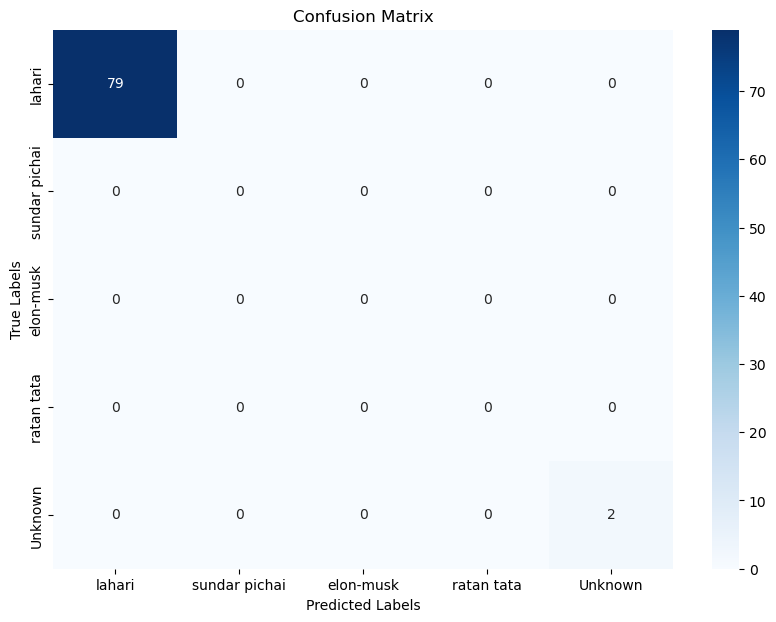

In [1]:
import cv2
import numpy as np
import pandas as pd
import face_recognition
import os
from datetime import datetime, time
from deepface import DeepFace
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directory where student images are stored
STUDENT_DIR = "students/"
ATTENDANCE_FILE = "attendance_log.csv"

def load_known_faces(directory=STUDENT_DIR):
    known_face_encodings = []
    known_face_names = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image = face_recognition.load_image_file(os.path.join(directory, filename))
            encoding = face_recognition.face_encodings(image)
            
            if encoding:
                known_face_encodings.append(encoding[0])
                known_face_names.append(os.path.splitext(filename)[0])
    
    return known_face_encodings, known_face_names

def initialize_attendance():
    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
        required_columns = ["Date", "Name", "Time", "Emotion", "Status"]
        if not all(col in df.columns for col in required_columns):
            print("⚠️ Attendance file is missing required columns. Resetting file.")
            return pd.DataFrame(columns=required_columns)
        return df
    return pd.DataFrame(columns=["Date", "Name", "Time", "Emotion", "Status"])

def is_within_time_range():
    now = datetime.now().time()
    start_time = time(9, 30, 0)
    end_time = time(10, 0, 0)
    return start_time <= now <= end_time

def save_attendance(attendance_df):
    attendance_df.to_csv(ATTENDANCE_FILE, index=False)

known_face_encodings, known_face_names = load_known_faces()
attendance_df = initialize_attendance()
today_date = datetime.now().strftime("%Y-%m-%d")

if not is_within_time_range():
    print("Attendance system is inactive. Try again between 9:30 AM and 10:00 AM.")
    exit()

print("✅ Attendance system is active.")

present_students = set()
y_true = []  # True labels
y_pred = []  # Predicted labels

cap = cv2.VideoCapture(0)

while is_within_time_range():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    emotion = "Unknown"
    try:
        emotion_analysis = DeepFace.analyze(frame, actions=["emotion"], enforce_detection=False)
        if emotion_analysis:
            emotion = emotion_analysis[0]["dominant_emotion"]
    except:
        pass

    for face_encoding, face_location in zip(face_encodings, face_locations):
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"
        
        if True in matches:
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]
            y_pred.append(name)
        else:
            y_pred.append("Unknown")
        
        y_true.append(name if name in known_face_names else "Unknown")
        
        if name != "Unknown" and name not in present_students:
            new_entry = pd.DataFrame([{
                "Date": today_date,
                "Name": name,
                "Time": datetime.now().strftime("%H:%M:%S"),
                "Emotion": emotion,
                "Status": "Present"
            }])
            attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
            present_students.add(name)
            save_attendance(attendance_df)
            print(f"✅ {name} marked as Present at {datetime.now().strftime('%H:%M:%S')}")

        top, right, bottom, left = face_location
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame, f"{name} ({emotion})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    cv2.imshow("Attendance System", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

for student in known_face_names:
    if student not in present_students:
        if attendance_df[(attendance_df["Name"] == student) & (attendance_df["Date"] == today_date)].empty:
            new_entry = pd.DataFrame([{
                "Date": today_date,
                "Name": student,
                "Time": "N/A",
                "Emotion": "N/A",
                "Status": "Absent"
            }])
            attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
            print(f"❌ {student} marked as Absent")

save_attendance(attendance_df)
print("✅ Final attendance logged successfully.")

if y_true and y_pred:
    accuracy = accuracy_score(y_true, y_pred)
    print(f"🔍 Accuracy: {accuracy * 100:.2f}%")
    
    conf_matrix = confusion_matrix(y_true, y_pred, labels=known_face_names + ["Unknown"])
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=known_face_names + ["Unknown"], yticklabels=known_face_names + ["Unknown"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


✅ Attendance system is active.


QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is not the object's thread (0x4d208020).
Cannot move to target thread (0x4d1ebee0)

QObject::moveToThread: Current thread (0x4d1ebee0) is n

✅ Final attendance logged successfully.
🎯 Model Accuracy: 88.89%


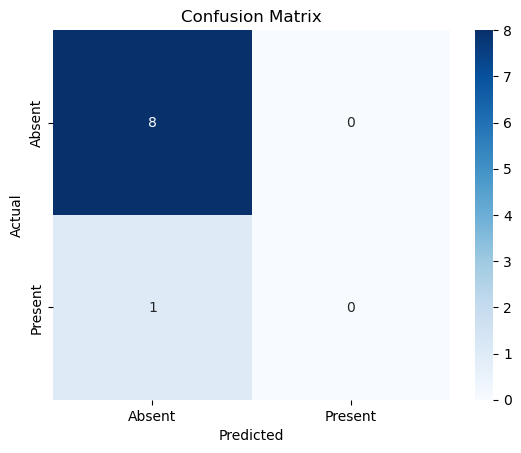

In [3]:
import cv2
import numpy as np
import pandas as pd
import face_recognition
import os
from datetime import datetime, time
from deepface import DeepFace
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directory where student images are stored
STUDENT_DIR = "students/"
ATTENDANCE_FILE = "attendance_log.csv"

# Load student images and create encodings
def load_known_faces(directory=STUDENT_DIR):
    known_face_encodings = []
    known_face_names = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image = face_recognition.load_image_file(os.path.join(directory, filename))
            encoding = face_recognition.face_encodings(image)
            
            if encoding:
                known_face_encodings.append(encoding[0])
                known_face_names.append(os.path.splitext(filename)[0])
    
    return known_face_encodings, known_face_names

# Initialize attendance tracking
def initialize_attendance():
    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
        required_columns = ["Date", "Name", "Time", "Emotion", "Status"]
        if not all(col in df.columns for col in required_columns):
            print("⚠️ Attendance file is missing required columns. Resetting file.")
            return pd.DataFrame(columns=required_columns)
        return df
    return pd.DataFrame(columns=["Date", "Name", "Time", "Emotion", "Status"])

# Check if current time is within allowed range (9:30 AM - 10:00 AM)
def is_within_time_range():
    now = datetime.now().time()
    start_time = time(9, 30, 0)
    end_time = time(10, 0, 0)
    return start_time <= now <= end_time

# Save attendance to CSV
def save_attendance(attendance_df):
    attendance_df.to_csv(ATTENDANCE_FILE, index=False)

# Load known faces
known_face_encodings, known_face_names = load_known_faces()
attendance_df = initialize_attendance()

today_date = datetime.now().strftime("%Y-%m-%d")

if not is_within_time_range():
    print("Attendance system is inactive. Try again between 9:30 AM and 10:00 AM.")
    exit()

print("✅ Attendance system is active.")

present_students = set()
cap = cv2.VideoCapture(0)

while is_within_time_range():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    emotion = "Unknown"
    try:
        emotion_analysis = DeepFace.analyze(frame, actions=["emotion"], enforce_detection=False)
        if emotion_analysis:
            emotion = emotion_analysis[0]["dominant_emotion"]
    except:
        pass

    for face_encoding, face_location in zip(face_encodings, face_locations):
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"
        
        if True in matches:
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]
        
        if name != "Unknown":
            existing_entries = attendance_df[(attendance_df["Name"] == name) & (attendance_df["Date"] == today_date)]
            if existing_entries.empty:
                new_entry = pd.DataFrame([{
                    "Date": today_date,
                    "Name": name,
                    "Time": datetime.now().strftime("%H:%M:%S"),
                    "Emotion": emotion,
                    "Status": "Present"
                }])
                attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
                present_students.add(name)
                save_attendance(attendance_df)
                print(f"✅ {name} marked as Present at {datetime.now().strftime('%H:%M:%S')}")

        top, right, bottom, left = face_location
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame, f"{name} ({emotion})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Attendance System", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Mark absent students
for student in known_face_names:
    if student not in present_students:
        if attendance_df[(attendance_df["Name"] == student) & (attendance_df["Date"] == today_date)].empty:
            new_entry = pd.DataFrame([{
                "Date": today_date,
                "Name": student,
                "Time": "N/A",
                "Emotion": "N/A",
                "Status": "Absent"
            }])
            attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
            print(f"❌ {student} marked as Absent")

save_attendance(attendance_df)

print("✅ Final attendance logged successfully.")

# Accuracy Calculation
y_true = attendance_df["Status"].apply(lambda x: 1 if x == "Present" else 0).values
y_pred = [1 if name in present_students else 0 for name in attendance_df["Name"]]
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Absent", "Present"], yticklabels=["Absent", "Present"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import cv2
import numpy as np
import pandas as pd
import face_recognition
import os
from datetime import datetime, time
from deepface import DeepFace
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Directory where student images are stored
STUDENT_DIR = "students/"
ATTENDANCE_FILE = "attendance_log.csv"

# Load student images and create encodings
def load_known_faces(directory=STUDENT_DIR):
    known_face_encodings = []
    known_face_names = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image = face_recognition.load_image_file(os.path.join(directory, filename))
            encoding = face_recognition.face_encodings(image)
            
            if encoding:
                known_face_encodings.append(encoding[0])
                known_face_names.append(os.path.splitext(filename)[0])
    
    return known_face_encodings, known_face_names

# Initialize attendance tracking
def initialize_attendance():
    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
        required_columns = ["Date", "Name", "Time", "Emotion", "Status"]
        if not all(col in df.columns for col in required_columns):
            print("⚠️ Attendance file is missing required columns. Resetting file.")
            return pd.DataFrame(columns=required_columns)
        return df
    return pd.DataFrame(columns=["Date", "Name", "Time", "Emotion", "Status"])

# Check if current time is within allowed range (9:30 AM - 10:00 AM)
def is_within_time_range():
    now = datetime.now().time()
    start_time = time(9, 30, 0)
    end_time = time(10, 0, 0)
    return start_time <= now <= end_time

# Save attendance to CSV
def save_attendance(attendance_df):
    attendance_df.to_csv(ATTENDANCE_FILE, index=False)

# Load known faces
known_face_encodings, known_face_names = load_known_faces()
attendance_df = initialize_attendance()

today_date = datetime.now().strftime("%Y-%m-%d")

if not is_within_time_range():
    print("Attendance system is inactive. Try again between 9:30 AM and 10:00 AM.")
    exit()

print("✅ Attendance system is active.")

present_students = set()
cap = cv2.VideoCapture(0)
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    while is_within_time_range():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        emotion = "Unknown"
        try:
            emotion_analysis = DeepFace.analyze(frame, actions=["emotion"], enforce_detection=False)
            if emotion_analysis:
                emotion = emotion_analysis[0]["dominant_emotion"]
        except:
            pass

        for face_encoding, face_location in zip(face_encodings, face_locations):
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"
            
            if True in matches:
                first_match_index = matches.index(True)
                name = known_face_names[first_match_index]
            
            if name != "Unknown":
                existing_entries = attendance_df[(attendance_df["Name"] == name) & (attendance_df["Date"] == today_date)]
                if existing_entries.empty:
                    new_entry = pd.DataFrame([{
                        "Date": today_date,
                        "Name": name,
                        "Time": datetime.now().strftime("%H:%M:%S"),
                        "Emotion": emotion,
                        "Status": "Present"
                    }])
                    attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
                    present_students.add(name)
                    save_attendance(attendance_df)
                    print(f"✅ {name} marked as Present at {datetime.now().strftime('%H:%M:%S')}")

            top, right, bottom, left = face_location
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(frame, f"{name} ({emotion})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow("Attendance System", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# Mark absent students
for student in known_face_names:
    if student not in present_students:
        if attendance_df[(attendance_df["Name"] == student) & (attendance_df["Date"] == today_date)].empty:
            new_entry = pd.DataFrame([{
                "Date": today_date,
                "Name": student,
                "Time": "N/A",
                "Emotion": "N/A",
                "Status": "Absent"
            }])
            attendance_df = pd.concat([attendance_df, new_entry], ignore_index=True)
            print(f"❌ {student} marked as Absent")

save_attendance(attendance_df)

print("✅ Final attendance logged successfully.")

# Accuracy Calculation
y_true = attendance_df["Status"].apply(lambda x: 1 if x == "Present" else 0).values
y_pred = [1 if name in present_students else 0 for name in attendance_df["Name"]]
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Absent", "Present"], yticklabels=["Absent", "Present"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=["Absent", "Present"])
print("Classification Report:\n", report)


2025-03-20 18:07:27.671352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 18:07:27.678398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 18:07:27.728564: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 18:07:27.760942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742494047.795932    6210 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742494047.80